In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transforms_utils import RepeatChannels


In [2]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_val):
        return (input_val > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output


class DenseShiftConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, T_val,
                 stride=1, padding=0, dilation=1, groups=1, bias=True, low_var_init_std=0.001):
        super(DenseShiftConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding if isinstance(padding, tuple) else (padding, padding)
        self.dilation = dilation if isinstance(dilation, tuple) else (dilation, dilation)
        self.groups = groups
        self.T_val = T_val

        self.w_scales = nn.ParameterList([
            nn.Parameter(torch.Tensor(out_channels, in_channels // groups, *self.kernel_size))
            for _ in range(T_val)
        ])
        self.w_sign = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, *self.kernel_size))

        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.low_var_init_std = low_var_init_std
        self.reset_parameters()

        self.current_S_T_matrix = None
        self._register_gradient_hook()

    def reset_parameters(self):
        for param in self.w_scales:
            nn.init.normal_(param, mean=0, std=self.low_var_init_std)
        nn.init.normal_(self.w_sign, mean=0, std=self.low_var_init_std)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def _calculate_S_T(self):
        s_val = torch.zeros_like(self.w_scales[0], device=self.w_scales[0].device)
        for i in range(self.T_val):
            s_val = STEFunction.apply(self.w_scales[i]) * (s_val + 1.0)
        return s_val

    def _register_gradient_hook(self):
        def hook_fn(grad):
            if self.current_S_T_matrix is not None:
                s_t_detached = self.current_S_T_matrix.detach()
                scale_val_2_pow_S_T = torch.pow(2.0, s_t_detached)
                sqrt_S_T_plus_1 = torch.sqrt(s_t_detached + 1.0)
                scaling_factor = sqrt_S_T_plus_1 / (scale_val_2_pow_S_T + 1e-9)
                return grad * scaling_factor
            return grad

        if self.w_sign.requires_grad:
            self.w_sign.register_hook(hook_fn)

    def forward(self, x):
        self.current_S_T_matrix = self._calculate_S_T()
        sign_matrix = 2 * STEFunction.apply(self.w_sign) - 1.0
        scale_matrix = torch.pow(2.0, self.current_S_T_matrix)
        quantized_weight = sign_matrix * scale_matrix

        return F.conv2d(x, quantized_weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def __repr__(self):
        return (f"DenseShiftConv2d({self.in_channels}, {self.out_channels}, kernel_size={self.kernel_size}, "
                f"stride={self.stride}, padding={self.padding}, T_val={self.T_val}, bias={self.bias is not None})")


In [3]:
def convert_model_to_denseshift(module, T_val, module_name_prefix=""):
    for child_name, child_module in module.named_children():
        full_child_name = f"{module_name_prefix}.{child_name}" if module_name_prefix else child_name
        if isinstance(child_module, nn.Conv2d):
            new_layer = DenseShiftConv2d(
                in_channels=child_module.in_channels,
                out_channels=child_module.out_channels,
                kernel_size=child_module.kernel_size,
                T_val=T_val,
                stride=child_module.stride,
                padding=child_module.padding,
                dilation=child_module.dilation,
                groups=child_module.groups,
                bias=child_module.bias is not None,
                low_var_init_std=0.001
            )
            if child_module.bias is not None and new_layer.bias is not None:
                with torch.no_grad():
                    new_layer.bias.data.copy_(child_module.bias.data)

            setattr(module, child_name, new_layer)
        else:
            convert_model_to_denseshift(child_module, T_val, full_child_name)


In [4]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def evaluate(model, device, loader, is_validation=False):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)

    eval_type = "Validation" if is_validation else "Test"
    print(
        f'{eval_type} set: Average loss: {total_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({accuracy:.2f}%)')
    return accuracy, total_loss


In [5]:
def main():
    batch_size = 64
    epochs = 2  
    lr = 0.01
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f"Using device: {device}")

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        RepeatChannels(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('../data', train=False, transform=transform)

    train_size = int(0.9 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2 if use_cuda else 0,
                              pin_memory=True if use_cuda else False)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2 if use_cuda else 0,
                            pin_memory=True if use_cuda else False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2 if use_cuda else 0,
                             pin_memory=True if use_cuda else False)

    configurations = [
        {'name': 'FP32 (Fine-tuned)', 'W_bw': None, 'T_val': None, 'is_denseshift': False},
        {'name': 'DenseShift (4-bit)', 'W_bw': 4, 'T_val': 2 ** (4 - 1) - 1, 'is_denseshift': True},  # T=7
        {'name': 'DenseShift (3-bit)', 'W_bw': 3, 'T_val': 2 ** (3 - 1) - 1, 'is_denseshift': True},  # T=3
        {'name': 'DenseShift (2-bit)', 'W_bw': 2, 'T_val': 2 ** (2 - 1) - 1, 'is_denseshift': True},  # T=1
    ]

    results_accuracy = []
    results_bit_width = []
    config_names = []

    for config in configurations:
        print(f"\n--- Running Configuration: {config['name']} ---")
        config_names.append(config['name'])

        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, 10) 

        if config['is_denseshift']:
            convert_model_to_denseshift(model, config['T_val'])
            current_bit_width = config['W_bw']
        else:
            current_bit_width = 32

        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        best_val_accuracy = 0
        final_test_accuracy_at_best_val = 0

        for epoch in range(1, epochs + 1):
            train(model, device, train_loader, optimizer, epoch)
            val_accuracy, _ = evaluate(model, device, val_loader, is_validation=True)
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                test_accuracy, _ = evaluate(model, device, test_loader, is_validation=False)
                final_test_accuracy_at_best_val = test_accuracy

        print(f"Final Test Accuracy for {config['name']} (at best validation): {final_test_accuracy_at_best_val:.2f}%")
        results_accuracy.append(final_test_accuracy_at_best_val)
        results_bit_width.append(current_bit_width)

    return results_accuracy, results_bit_width, config_names


In [6]:
results_accuracy, results_bit_width, config_names = main()

Using device: cuda

--- Running Configuration: FP32 (Fine-tuned) ---
Train Epoch: 1 [0/54000 (0%)]	Loss: 2.547104
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.365580
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.308522
Train Epoch: 1 [19200/54000 (36%)]	Loss: 0.259837
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.054474
Train Epoch: 1 [32000/54000 (59%)]	Loss: 0.034057
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.074930
Train Epoch: 1 [44800/54000 (83%)]	Loss: 0.007688
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.079700
Validation set: Average loss: 0.1606, Accuracy: 5735/6000 (95.58%)
Test set: Average loss: 0.1560, Accuracy: 9540/10000 (95.40%)
Train Epoch: 2 [0/54000 (0%)]	Loss: 0.115094
Train Epoch: 2 [6400/54000 (12%)]	Loss: 0.034897
Train Epoch: 2 [12800/54000 (24%)]	Loss: 0.016466
Train Epoch: 2 [19200/54000 (36%)]	Loss: 0.003113
Train Epoch: 2 [25600/54000 (47%)]	Loss: 0.052665
Train Epoch: 2 [32000/54000 (59%)]	Loss: 0.025839
Train Epoch: 2 [38400/54000 (71%)]	Loss: 0.040993
Train Epoch: 2


Plot saved as denseshift_resnet18_mnist_transferlearning.png


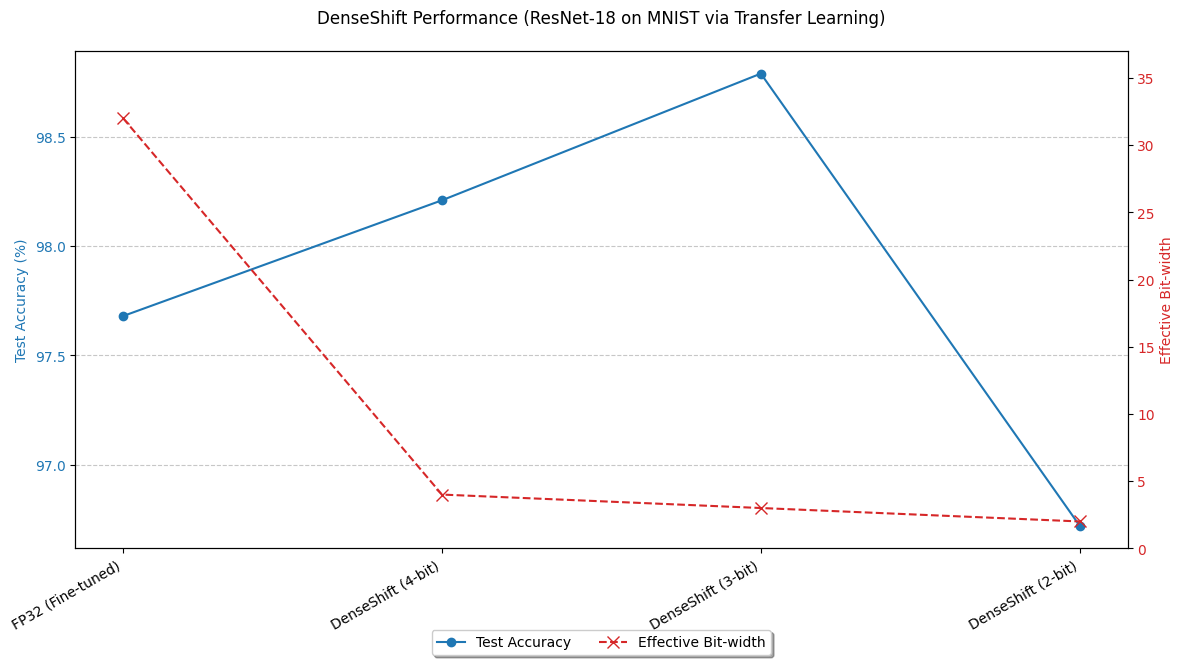

In [7]:
def plot_results(results_accuracy, results_bit_width, config_names):
    fig, ax1 = plt.subplots(figsize=(12, 7))

    color = 'tab:blue'
    ax1.set_xlabel('Model Configuration')
    ax1.set_ylabel('Test Accuracy (%)', color=color)
    ax1.plot(config_names, results_accuracy, color='tab:blue', marker='o', linestyle='-', label='Test Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(range(len(config_names)))
    ax1.set_xticklabels(config_names, rotation=30, ha="right")
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Effective Bit-width', color=color)
    ax2.plot(config_names, results_bit_width, color=color, marker='x', linestyle='--', markersize=8,
             label='Effective Bit-width')
    ax2.tick_params(axis='y', labelcolor=color)

    if results_bit_width:
        min_bw = min(filter(lambda x: x is not None, results_bit_width))
        max_bw = max(filter(lambda x: x is not None, results_bit_width))
        if min_bw is not None and max_bw is not None:
            ax2.set_ylim(0, max_bw + 5 if max_bw > 5 else 10)

    fig.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout
    plt.title('DenseShift Performance (ResNet-18 on MNIST via Transfer Learning)', pad=20)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True,
               shadow=True, ncol=2)

    plt.savefig("denseshift_resnet18_mnist_transferlearning.png", bbox_inches='tight')
    print("\nPlot saved as denseshift_resnet18_mnist_transferlearning.png")
    plt.show()

plot_results(results_accuracy, results_bit_width, config_names)
